# Homework 5: Neural Networks (100 points)

In this homework, you will be implementing a fully connected neural network and a convolutional neural network using the PyTorch framework.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Load the Dataset (MNIST)

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

# Plotting Data

You must sample 10 images (one from each class) from the dataset and plot them as a grid with 2 rows of 5 columns each (i.e. of shape `2 x 5`).

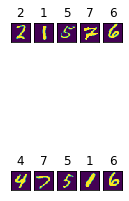

In [4]:
# TODO: Plot 10 images with one image from each class in the training set
images,labels = next(iter(train_loader))
npimg= images.numpy()

fig = plt.figure(figsize=(2, 5))
for index in range(0, 10):
    plt.subplot(2, 5, index + 1)
    plt.imshow(npimg[index].reshape(28, 28), interpolation='none')
    plt.title("{}".format(labels[index]))
    plt.xticks([])
    plt.yticks([])

## Train a Fully Connected Neural Network on MNIST

### Define the network

Build a 3-layer fully connected neural network that takes an input of size `784`, outputs `10` classes and has a hidden layer of size `(8,8)`. Use ReLU non-linearity and apply a logSoftmax function on the final layer.

The model must have the following architecture:

```
linear_layer(input_size, n_hidden)
relu
linear_layer(n_hidden, n_hidden)
relu
linear_layer(n_hidden, output_size)
log_softmax
```

In [5]:
class FCN(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FCN, self).__init__()
        # Inputs to hidden layer linear transformation       
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()   
        self.hidden1 = nn.Linear(input_size, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        # Output layer, 10 units - one for each digit
        self.hidden3 = nn.Linear(n_hidden, output_size)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass the input tensor through each of our operations       
        x = self.flatten(x)       
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.hidden3(x)    
        return x
    

### Define train and test function

Complete the function for training and evaluating the model. You must use the cross entropy loss function for training the model.

Note:
- `permute` is a function passed as an argument to train and test functions.
- `permutation_order` is a 1D torch array of size 784 (=28*28). It contains the random order for permutating the pixels in the `28x28` images.

In [6]:
loss_fn = nn.CrossEntropyLoss()

def train(epoch, model, optimizer, permute_pixels=None, permutation_order=None):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, permute_pixels=None, permutation_order=None):
    """
    Test the model

    Args:
        model (nn.Module): model to test
        permute (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        if permute_pixels is not None:
            data = permute_pixels(data, permutation_order)

        output = model(data)
        test_loss += loss_fn(output,target).item() # sum up batch loss                                                               
        pred = model(data)  # get the index of the max log-probability                                                                 
        correct += (pred.argmax(1)==target).type(torch.float).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return accuracy

# Write a function for computing the total parameter count of the model

In [7]:
# function to count number of parameters
def get_n_params(model):
    # return number of parameters in model
    return sum(param.numel() for param in model.parameters())

### Train a small fully-connected network

Optimizer : SGD with lr=0.01 and momentum=0.5

In [ ]:
n_hidden = 8 # number of hidden units

model_fcn = FCN(input_size, n_hidden, output_size)
model_fcn.to(device)
optimizer = optim.SGD(model_fcn.parameters(), lr=0.01, momentum=0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_fcn, optimizer)
    test_accuracy.append(test(model_fcn))

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.329760
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.936176
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.254391
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.996215
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.030686
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.567913
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.600678
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.425062
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.413005
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.401139


## Train a Convolutional Neural Network (CNN) on MNIST

Define a convolutional neural network with the following architecture to classify the MNIST images.

```
Conv(
    conv2D(input_size, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
    conv2d(conv_feature, conv_feature, kernel_size=5)
    relu()
    maxpool2d(kernel_size=2)
)

FC(
    linear_feature(conv_feature*4*4, fc_feature),
    relu(),
    linear_feature(fc_feature, output_size),
    log_softmax()
)
```

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        #declare self methods
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)
        self.input_size = input_size
        self.conv_feature = conv_feature
        self.fc_feature = fc_feature
        self.output_size = output_size
        
        #Conv & FC
        self.conv2d1 = nn.Conv2d(input_size, conv_feature, 5)
        self.conv2d2 = nn.Conv2d(conv_feature, conv_feature, 5)
        self.maxpool2d1 = nn.MaxPool2d(kernel_size=2)
        self.maxpool2d2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(conv_feature*4*4, fc_feature)
        self.fc2 = nn.Linear(fc_feature, output_size)

    def forward(self, x):
        x = F.relu(self.conv2d1(x))
        x = self.maxpool2d1(x)
        x = F.relu(self.conv2d2(x))
        x = self.maxpool2d2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.log_softmax(self.fc2(x))
        return x

### Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50
input_size = 1

model_cnn = CNN(input_size, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(),lr = 0.01, momentum = 0.5)  # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

test_accuracy = []
for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test_accuracy.append(test(model_cnn))

### Question: Why do you think the ConvNet performs better than the fully connected network even though both have the same number of parameters?


Convolutions are not densely connected, not all input nodes affect all output nodes. This gives convolutional layers more flexibility in learning. Moreover, the number of weights per layer is a lot smaller, which helps a lot with high-dimensional inputs such as image data. 

### What happens if the assumptions are no longer true?

In [ ]:
# Given a permutation order, permute the pixels of the input image
def permute_pixels(data, permutation_order):
    """
    Permute the pixels of the input image
    
    Args:
        data (torch tensor): batch of input images of shape (B, H, W) where B is the batch size, H is the height and W is the width.
        permutation_order (1D torch array): order of the permutation
    
    Returns:
        permuted_data (torch tensor): permuted batch of input images of shape (B, 1, H, W)
    """  
    data = data.view(-1, 28*28)
    data = data[0:, permutation_order]   
    return data.view(-1, 1, 28, 28)

In [ ]:
permutation_order = torch.randperm(28*28)

plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = permute_pixels(image.clone(), permutation_order)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

### ConvNet with permuted pixels

Train and evaluate a ConvNet with permuted pixels.

In [ ]:
# Training settings 
conv_features = 6 # number of feature maps
fc_features = 50

model_cnn = CNN(input_size, conv_features, fc_features, output_size) # create CNN model
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(),lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, permute_pixels, permutation_order)
    test(model_cnn, permute_pixels, permutation_order)

### Fully-Connected with Permuted Pixels

Train and evaluate a fully connected network with permuted pixels.

In [ ]:
n_hidden = 8    # number of hidden units
input_size  = 28*28

model_fnn = FCN(input_size, n_hidden, output_size) # create FCN model
model_fnn.to(device)
optimizer = torch.optim.SGD(model_fnn.parameters(),lr = 0.01, momentum = 0.5) # use SGD with learning rate 0.01 and momentum 0.5
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, permute_pixels)
    test(model_fnn, permute_pixels)

### Question: We observe that the ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same. Provide an explanation for this.

ConvNet makes the assumption that pixels lie on a grid and are stationary/local, which means the assumption could influence its results. The assumption might be wrong and leads to decreasing performance. Meanwhile, FCN doesn't make assumptions since it doesn't learn from prior knowledge. 